In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
allocs = pd.Series([.3, .3, .35, .05, 1], index=['ES','NQ', 'GC', 'CL', 'total'])
#allocs = pd.Series([2/3, 1/3, 1], index=['ES','NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/blotter/blotter_2020-03-15_21-15_week_6.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [24]:
df.groupby('contract').realizedPNL.sum()

contract
CL    6381.04
ES   -9841.80
GC   -1187.12
NQ   -5306.80
Name: realizedPNL, dtype: float64

In [6]:
df.realizedPNL.sum()

-9954.68

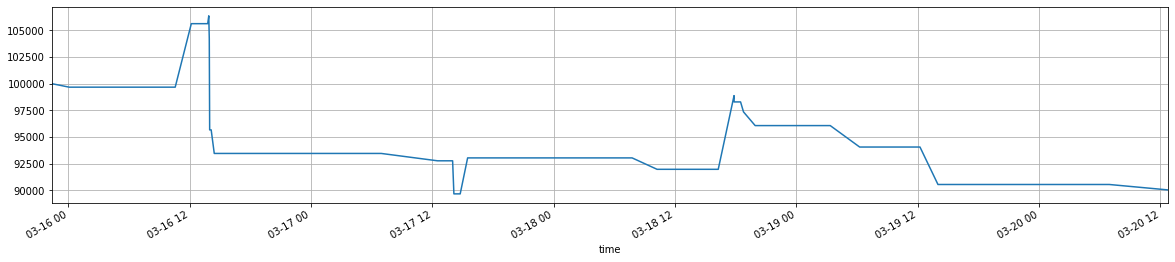

In [7]:
df.cash.plot(figsize=(20,4), grid=True);

In [8]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [9]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
CL     8
ES     5
GC    18
NQ     4
Name: action, dtype: int64

In [10]:
# commission paid
df.groupby('contract').commission.sum()

contract
CL    18.96
ES    21.00
GC    87.12
NQ    16.80
Name: commission, dtype: float64

In [11]:
df.commission.sum()

143.88000000000002

In [12]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
CL,0.50,1595.26,3820.26,-629.74,6.07,1595.26,4.0
GC,0.22,-131.90,4660.32,-1501.11,3.10,-145.60,9.0
ES,0.00,-4920.90,NaN,-4920.90,NaN,NaN,2.0
NQ,0.00,-2653.40,NaN,-2653.40,NaN,NaN,2.0
total,0.24,-585.57,4240.29,-2070.45,2.05,-555.87,17.0


In [13]:
daily = by_contract.resample('B').sum()
daily = daily.cumsum() +  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [14]:
# instrument correlations
log_returns = np.log(daily.pct_change()[1:] + 1)
log_returns.corr()

,CL,ES,GC,NQ,total
CL,1.000000,-0.036852,-0.128133,0.360827,0.658388
ES,-0.036852,1.000000,-0.607665,0.316284,0.509730
GC,-0.128133,-0.607665,1.000000,-0.784532,-0.025797
NQ,0.360827,0.316284,-0.784532,1.000000,0.175158
total,0.658388,0.509730,-0.025797,0.175158,1.000000


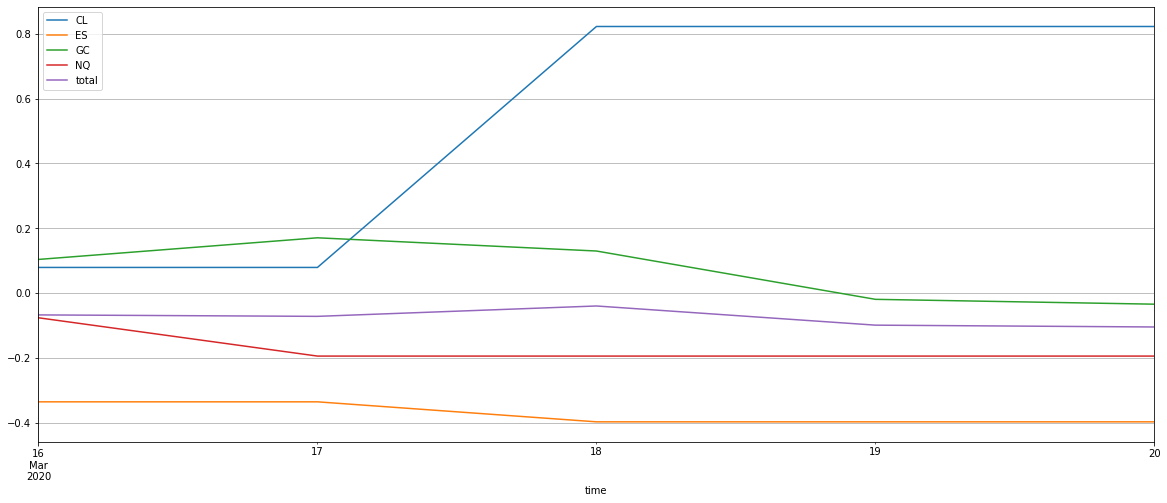

In [15]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

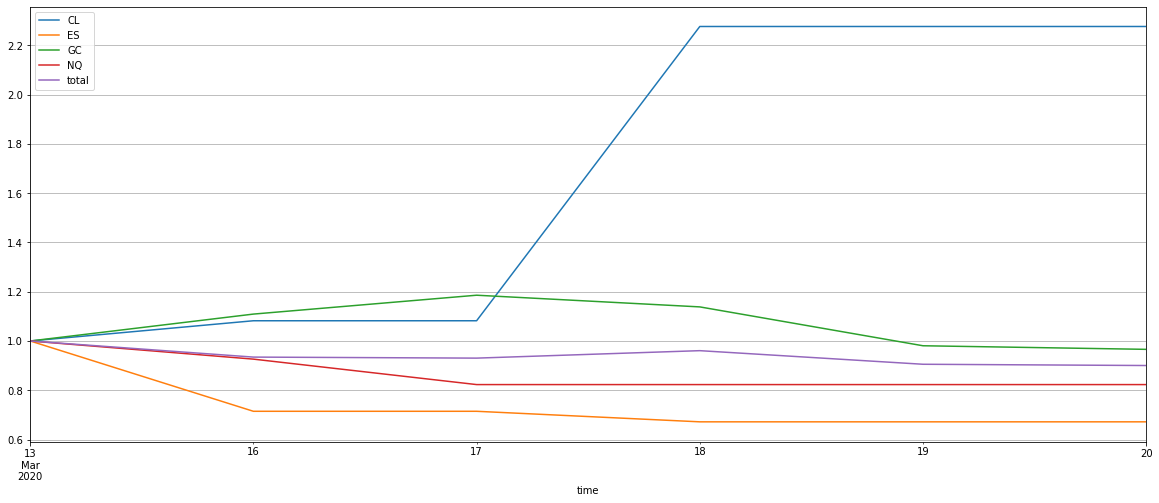

In [16]:
returns = daily.pct_change()
returns.iloc[0] = (daily.iloc[0] / (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [17]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,CL,ES,GC,NQ,total
Annual return,1.006704e+15,-1.000000,-0.765257,-0.999719,-0.987772
Cumulative returns,1.276208e+00,-0.328060,-0.033918,-0.176893,-0.099547
Annual volatility,7.064355e+00,1.811563,1.377633,0.782145,0.594121
Sharpe ratio,7.048832e+00,-8.001763,-0.461924,-9.939606,-7.094939
Calmar ratio,NaN,-3.048223,-4.130786,-5.651534,-9.922686
Stability,8.032182e-01,0.592358,0.128478,0.708583,0.643157
Max drawdown,0.000000e+00,-0.328060,-0.185257,-0.176893,-0.099547
Omega ratio,NaN,0.000000,0.921643,0.000000,0.244841
Sortino ratio,inf,-7.673409,-0.677430,-8.979120,-7.449412
Skew,1.767634e+00,-1.629487,-0.271638,-0.888540,-0.230068


In [18]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,CL,ES,GC,NQ,total
time,,,,,
2020-03-31 00:00:00+00:00,127.62,-32.81,-3.39,-17.69,-9.95


In [19]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

CL       128.0
ES       -33.0
GC        -3.0
NQ       -18.0
total    -10.0
dtype: float64

In [20]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2020-03-18 17:49:51.727254+00:00,CL,BUY,21.62,6905.26
2020-03-16 12:09:37.543377+00:00,GC,BUY,1475.50,5950.32
2020-03-17 15:29:05.638770+00:00,GC,SELL,1534.60,3370.32
2020-03-16 13:53:14.717494+00:00,CL,BUY,29.22,735.26
2020-03-15 22:23:30.924668+00:00,CL,SELL,30.57,0.00
2020-03-16 19:58:00.806659+00:00,ES,SELL,2385.75,0.00
2020-03-18 07:45:01.135191+00:00,GC,SELL,1502.30,0.00
2020-03-17 14:45:00.676739+00:00,GC,BUY,1517.70,0.00
2020-03-17 14:00:00.674426+00:00,NQ,SELL,6982.50,0.00
